In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA


In [2]:
sentence = "The cat sits on the mat."


In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Tokens:")
for t, i in zip(tokens, token_ids):
    print(f"{t:>10} -> {i}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokens:
       the -> 1996
       cat -> 4937
      sits -> 7719
        on -> 2006
       the -> 1996
       mat -> 13523
         . -> 1012


In [4]:
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

inputs = tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# last_hidden_state: [batch, seq_len, hidden_dim]
embeddings = outputs.last_hidden_state[0]  # [seq_len, hidden_dim]
print("Embedding shape:", embeddings.shape)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.numpy())

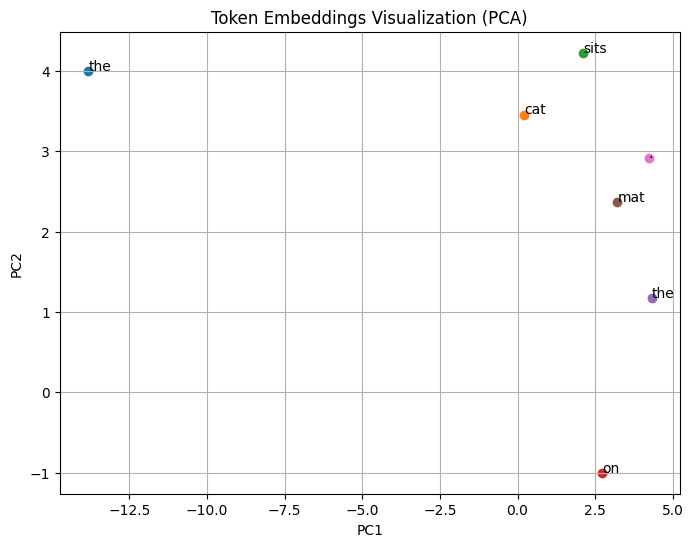

In [6]:
plt.figure(figsize=(8, 6))

for i, token in enumerate(tokens):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, token)

plt.title("Token Embeddings Visualization (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [8]:
sentences = [
    # 動物
    "The cat sits on the mat.",
    "A dog is playing in the park.",
    "The bird is flying in the sky.",

    # 技術・AI
    "Deep learning models require large datasets.",
    "Neural networks are trained using backpropagation.",
    "Transformers are powerful language models.",

    # 経済・社会
    "The stock market crashed during the recession.",
    "Inflation affects the global economy.",
    "Economic growth depends on productivity.",

    # 日常会話
    "I am feeling very happy today.",
    "This movie was really boring.",
    "I am looking forward to the weekend."
]


In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
sentence_embeddings = []

with torch.no_grad():
    for s in sentences:
        inputs = tokenizer(s, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)

        # [CLS] token = 文全体の意味表現
        cls_embedding = outputs.last_hidden_state[0, 0]  # shape: [768]
        sentence_embeddings.append(cls_embedding.numpy())

sentence_embeddings = np.array(sentence_embeddings)
print(sentence_embeddings.shape)


(12, 768)


In [12]:
pca = PCA(n_components=4)
embeddings_pca = pca.fit_transform(sentence_embeddings)


In [13]:
tsne = TSNE(
    n_components=2,
    perplexity=5,
    random_state=42,
    init="pca",
    learning_rate="auto"
)

embeddings_2d = tsne.fit_transform(embeddings_pca)


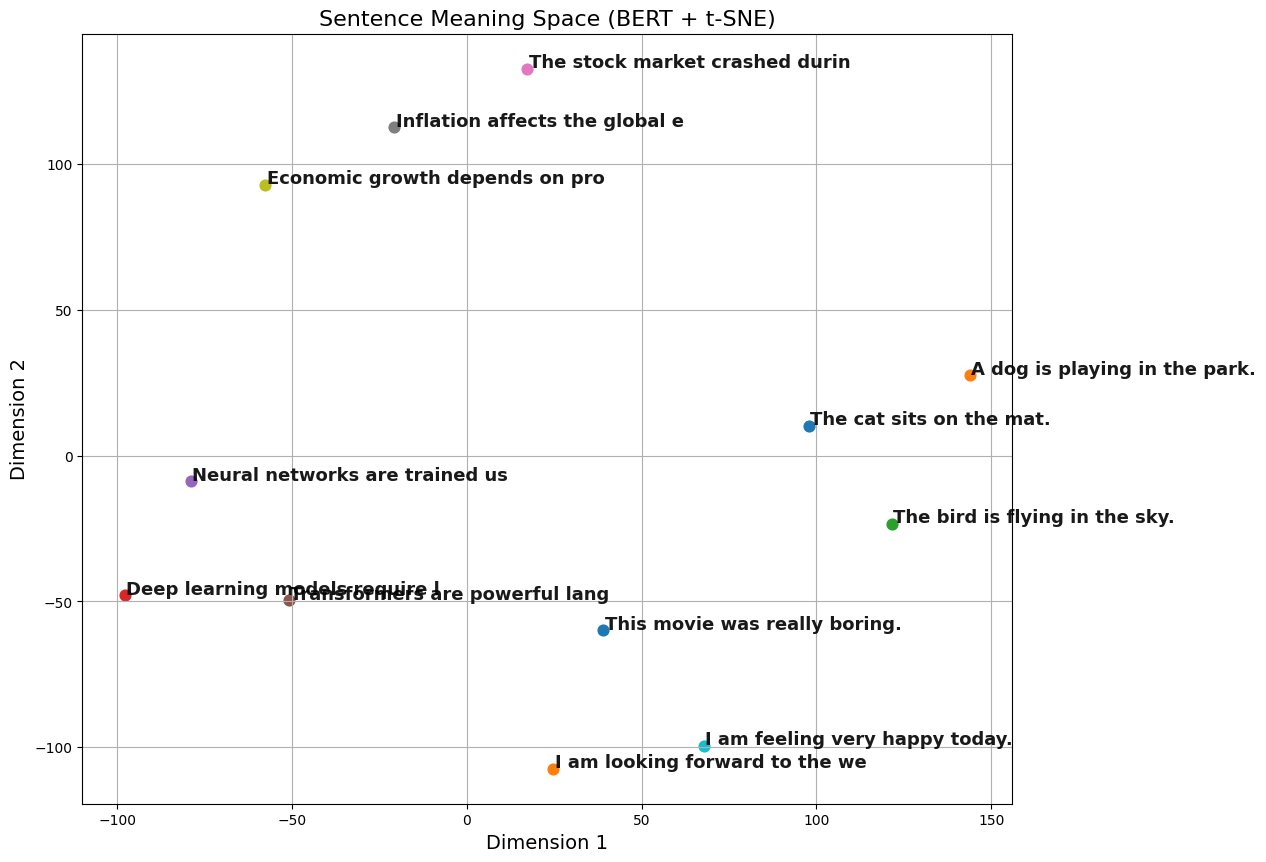

In [15]:
plt.figure(figsize=(12, 10))

for i, sentence in enumerate(sentences):
    x, y = embeddings_2d[i]

    plt.scatter(x, y, s=60)  # 点も少し大きく
    plt.text(
        x + 0.4,
        y + 0.4,
        sentence[:30],
        fontsize=13,          # ← 文字サイズ
        fontweight="bold",    # ← 太字
        alpha=0.9
    )

plt.title("Sentence Meaning Space (BERT + t-SNE)", fontsize=16)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)
plt.grid(True)
plt.show()


エラーログの詳細をありがとうございます。原因が明確に判明しました。

エラーの核心は **「ハードウェア（GPU）の世代が FlashAttention の要求スペックを満たしていないこと」** です。

### 1. エラーの原因：GPUの世代（SM 7.5）

ログの中に以下の重要なメッセージがあります：

> `Attempting to run on a sm 7.5 gpu.`

* **SM 7.5**：これは NVIDIA の **Turing 世代**（T4 や RTX 20系）を指します。
* **FlashAttention の要件**：**SM 8.0 以上**（Ampere 世代：A100, RTX 30系以降）が必要です。

つまり、Google Colab の無料版でよく割り当てられる **Tesla T4 (SM 7.5)** では、物理的に FlashAttention を動かすことができません。また、明示的に `enable_math=False`（標準の計算を禁止）にしたため、動かせるアルゴリズムが一つもなくなり `RuntimeError: No available kernel` となってしまいました。

---

### 2. 回避策：T4 GPU で高速化するには？

T4 GPU であっても、FlashAttention ほどではありませんが **「Memory Efficient Attention (xFormers)」** という別の高速化技術が使えます。

コードを以下のように修正して試してみてください。

```python
import torch
import torch.nn.functional as F

# T4 GPU (SM 7.5) でも動作する設定
q = torch.randn(1, 8, 1024, 64).cuda().half()
k = torch.randn(1, 8, 1024, 64).cuda().half()
v = torch.randn(1, 8, 1024, 64).cuda().half()

# 最新の推奨される書き方 (sdpa_kernel を使用)
from torch.nn.attention import sdpa_kernel, SDPBackend

# enable_flash=False にし、Memory Efficient を有効にする
with sdpa_kernel([SDPBackend.EFFICIENT_ATTENTION]):
    output = F.scaled_dot_product_attention(q, k, v)
    print("Memory Efficient Attention で実行成功！")

```

---

### 3. 未来的・実践的なアドバイス

もしどうしても本物の **FlashAttention** を試したい、あるいは **Unsloth** で Llama 3 などを爆速で学習させたい場合は、以下のいずれかの対応が必要になります。

1. **Colab Pro にアップグレード**: A100 や L4 (SM 8.9) を選択すれば、FlashAttention が動きます。
2. **実行環境を変える**: ローカルに RTX 30系/40系がある場合、そちらで実行する。
3. **Unsloth の自動最適化に任せる**:
Unsloth は T4 GPU を検知すると、自動的に「FlashAttention は使わずに、T4 で動く最速のカーネル」に切り替えてくれます。そのため、自分で `sdp_kernel` を指定せず、Unsloth のライブラリに任せるのが最もスムーズです。

**現在の環境（T4など）で、他に高速化を試したいライブラリや手法はありますか？（例えば、量子化の bitsandbytes など）**

In [1]:
import torch
import torch.nn.functional as F

# GPU（Ampere世代以降：RTX 3090/4090, A100/H100等）が必要
q = torch.randn(1, 8, 1024, 64).cuda().half()
k = torch.randn(1, 8, 1024, 64).cuda().half()
v = torch.randn(1, 8, 1024, 64).cuda().half()

# 最適化された実装を強制的に指定することも可能
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
    output = F.scaled_dot_product_attention(q, k, v)

/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
/tmp/ipython-input-1352652020.py:11: UserWarning: Memory efficient kernel not used because: (Triggered internally at /pytorch/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:915.)
  output = F.scaled_dot_product_attention(q, k, v)
/tmp/ipython-input-1352652020.py:11: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/sdp_utils_cpp.h:552.)
  output = F.scaled_dot_product_attention(q, k, v)
/tmp/ipython-input-1352652020.py:11: UserWarning: Flash attention kernel not used because: (Triggered internally at /pytorch/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:917.)
  output = F.scaled_dot_product_attention(q, k

RuntimeError: No available kernel. Aborting execution.

In [2]:
import torch
import torch.nn.functional as F

# T4 GPU (SM 7.5) でも動作する設定
q = torch.randn(1, 8, 1024, 64).cuda().half()
k = torch.randn(1, 8, 1024, 64).cuda().half()
v = torch.randn(1, 8, 1024, 64).cuda().half()

# 最新の推奨される書き方 (sdpa_kernel を使用)
from torch.nn.attention import sdpa_kernel, SDPBackend

# enable_flash=False にし、Memory Efficient を有効にする
with sdpa_kernel([SDPBackend.EFFICIENT_ATTENTION]):
    output = F.scaled_dot_product_attention(q, k, v)
    print("Memory Efficient Attention で実行成功！")

Memory Efficient Attention で実行成功！
